# Outlier Method of Filtering

**Mostafa Kamal Mostafa Kamel (mos.kamal@nu.edu.eg)**


## Eval


In [1]:
from seasalt.seasalt import apply_salt_pepper, signal_to_noise_ratio
from PIL import Image
from glob import glob
from pathlib import Path
import pandas as pd
from typing import Callable, Optional


import matplotlib.pyplot as plt
import numpy as np
from rich.progress import Progress

from scipy.signal import medfilt
import warnings
import seaborn as sns
from seasalt.fast_seasalt import fixed_window_outlier_filter
# from seasalt.cython_seasalt import fixed_window_outlier_filter

warnings.filterwarnings("ignore")
path_to_images = Path().resolve().joinpath("standard-images")
image_paths = glob(f"{str(path_to_images)}/*")


def plot_transformation_hist_eq(
    im, sp_ratio, size=3, max_size=15, save_path: Optional[str] = None
) -> float:
    im_gs = im.convert("L")
    arr = np.array(im_gs)  # convert the PIL image object to array
    seasoned_image = apply_salt_pepper(arr, ratio=sp_ratio)
    corrected_novel = fixed_window_outlier_filter(np.copy(seasoned_image), size)
    noisy_snr = signal_to_noise_ratio(im_gs, seasoned_image)
    novel_snr = signal_to_noise_ratio(im_gs, corrected_novel)
    fig = plt.figure(
        figsize=(
            12*3,
            5*3,
        ),
        dpi=80,
    )
    gs = fig.add_gridspec(1, 3, hspace=0.12, wspace=0.08)
    axes = gs.subplots(sharex="col", sharey="row")
    list(map(lambda ax: ax.set_axis_off(), axes.flatten()))
    list(  # type: ignore
        map(
            lambda input: input[0].set_title(input[1]),
            zip(
                axes.flatten(),
                [
                    "Original",
                    f"Noisy Image {round(noisy_snr, 2)} dB",
                    "Novel Approach\n" f"{round(novel_snr, 2)} dB",
                ],
            ),
        )
    )
    axes[0].imshow(im_gs, cmap="gray", vmin=0, vmax=255)
    axes[1].imshow(seasoned_image, cmap="gray", vmin=0, vmax=255)
    axes[2].imshow(corrected_novel, cmap="gray", vmin=0, vmax=255)
    if save_path:
        plt.axis("off")
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path)
        plt.close()
    return novel_snr

In [2]:
def plot_single_image(seasoned_arr):
    fig = plt.figure(
        figsize=(
            10,
            20,
        ),
        dpi=80,
    )
    gs = fig.add_gridspec(1, 1, hspace=0.12, wspace=0.08)
    ax = gs.subplots(sharex="col", sharey="row")
    ax.imshow(seasoned_arr, cmap="gray", vmin=0, vmax=255)
    ax.set_axis_off()

In [3]:
data_dict_eq = dict(
    im_index=[],
    sp=[],
    novel_snr=[],
)
root_path = Path().resolve().joinpath("aof_eval").joinpath("eq")

with Progress() as progress:
    task = progress.add_task("Running...", total=len(image_paths) * 10)
    for p in image_paths:
        img_name = p.split("/")[-1].split(".")[0]
        for sp, size in zip(
            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
            [3, 3, 3, 5, 7, 15, 15, 15, 15, 31],
        ):
            im = Image.open(p)
            novel_snr = plot_transformation_hist_eq(
                im,
                sp_ratio=sp,
                size=size,
                save_path=f"./images/20TTI-test/{p.split('/')[-1].split('.')[0]}/{int(sp*100)}.png",
            )
            data_dict_eq["im_index"].append(img_name)
            data_dict_eq["sp"].append(sp)
            data_dict_eq["novel_snr"].append(novel_snr)
            progress.update(task, advance=1)

Output()

In [4]:
sns.set_theme()

In [5]:
df_eq = pd.DataFrame(data_dict_eq)
df_eq.to_pickle("df_eq_20TTI.pkl")

In [6]:
df_eq.im_index.unique()

array(['hill', 'cameraman', 'woman_blonde', 'elaine', 'baboon',
       'flintstones', 'flower', 'pirate', 'house', 'bridge', 'lake',
       'einstein', 'woman_darkhair', 'boat', 'parrot', 'barbara',
       'jetplane', 'peppers_gray', 'livingroom', 'lena'], dtype=object)

In [7]:
df_eq[df_eq.im_index=="lena"]

,im_index,sp,novel_snr
190,lena,0.10,44.068757
191,lena,0.20,40.697614
192,lena,0.30,38.230618
193,lena,0.40,36.144687
194,lena,0.50,34.492432
195,lena,0.60,33.064056
196,lena,0.70,22.490655
197,lena,0.80,22.068792
198,lena,0.90,20.529821
199,lena,0.95,19.731526


In [8]:
df_eq[df_eq.im_index=="peppers_gray"]

,im_index,sp,novel_snr
170,peppers_gray,0.10,41.669841
171,peppers_gray,0.20,38.510337
172,peppers_gray,0.30,36.395744
173,peppers_gray,0.40,34.652285
174,peppers_gray,0.50,33.245985
175,peppers_gray,0.60,20.447902
176,peppers_gray,0.70,21.106083
177,peppers_gray,0.80,20.915045
178,peppers_gray,0.90,19.399151
179,peppers_gray,0.95,18.188102


In [9]:
df_eq[df_eq.im_index=="lake"]

,im_index,sp,novel_snr
100,lake,0.10,39.853670
101,lake,0.20,36.352366
102,lake,0.30,34.069916
103,lake,0.40,31.942021
104,lake,0.50,30.395510
105,lake,0.60,28.757159
106,lake,0.70,19.035186
107,lake,0.80,19.409778
108,lake,0.90,18.735139
109,lake,0.95,17.235035


In [10]:
df_eq[df_eq.im_index=="woman_darkhair"]

,im_index,sp,novel_snr
120,woman_darkhair,0.10,49.506506
121,woman_darkhair,0.20,45.759883
122,woman_darkhair,0.30,43.148843
123,woman_darkhair,0.40,41.866539
124,woman_darkhair,0.50,40.078511
125,woman_darkhair,0.60,27.964941
126,woman_darkhair,0.70,28.580857
127,woman_darkhair,0.80,27.473585
128,woman_darkhair,0.90,18.579255
129,woman_darkhair,0.95,19.833560


In [11]:
df_aof_agg = df_eq.groupby("sp").agg(
    {
        "novel_snr": [np.mean],
    }
)

In [12]:
df_aof_agg = df_aof_agg.reset_index()
df_aof_agg.columns = [
    "sp",
    "mean_novel_snr",
]

In [13]:
df_aof_agg

,sp,mean_novel_snr
0,0.10,38.736172
1,0.20,35.989079
2,0.30,33.847034
3,0.40,32.288114
4,0.50,30.886810
5,0.60,24.176327
6,0.70,21.666060
7,0.80,21.419695
8,0.90,19.564121
9,0.95,18.574580


In [14]:
df_melted = df_aof_agg.melt(id_vars="sp", var_name="variable", value_name="value")
df_melted

,sp,variable,value
0,0.10,mean_novel_snr,38.736172
1,0.20,mean_novel_snr,35.989079
2,0.30,mean_novel_snr,33.847034
3,0.40,mean_novel_snr,32.288114
4,0.50,mean_novel_snr,30.886810
5,0.60,mean_novel_snr,24.176327
6,0.70,mean_novel_snr,21.666060
7,0.80,mean_novel_snr,21.419695
8,0.90,mean_novel_snr,19.564121
9,0.95,mean_novel_snr,18.574580


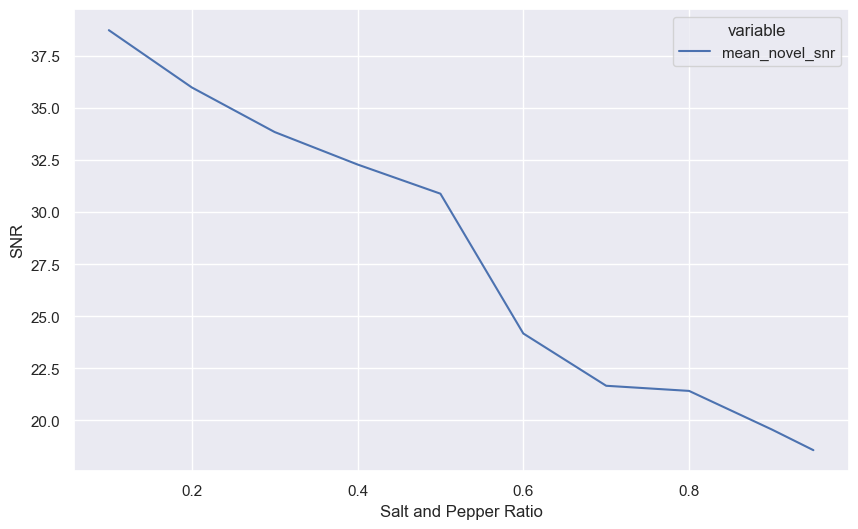

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_melted[
        df_melted.variable.isin(
            [
                "mean_novel_snr",
            ]
        )
    ],
    x="sp",
    y="value",
    hue="variable",
)

plt.xlabel("Salt and Pepper Ratio")
plt.ylabel("SNR")
plt.show()